In [121]:
import pandas as pd
import matplotlib
from fbprophet import Prophet
from tqdm.notebook import tqdm
from itertools import product
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sn
import numpy as np
import plotly.graph_objs as go


red = "#E07182"
green = "#96D6B4"
blue = "#4487D3"
grey = "#87878A"

cm = sn.light_palette(red, as_cmap=True)

# Load Data

Data downloaded from https://deis.minsal.cl/#datosabiertos

In [122]:
path = "../data/defunciones_deis.csv"
deaths = pd.read_csv(path, encoding='latin1', sep=';', header=None)
cols_map = {
    0: 'year',
    1: 'date',
    2: 'gender',
    4: 'age',
    6: 'comuna',
    7: 'region',
    10: 'cause',
    12: 'detail',
    8: 'icd10'
    
}
deaths.rename(columns=cols_map, inplace=True)
deaths = deaths[list(cols_map.values())]
deaths['date'] = pd.to_datetime(deaths['date'])
deaths.loc[deaths.icd10 == "U071", 'detail'] = "Confirmed COVID-19"
deaths.loc[deaths.icd10 == "U072", 'detail'] = "Suspected COVID-19"
deaths.loc[deaths.icd10.isin(["U071", "U072"]), 'cause'] = "COVID-19"

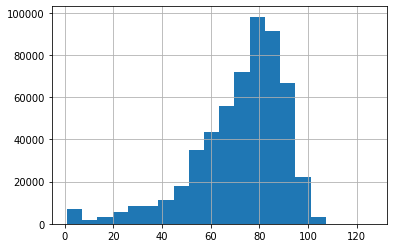

In [123]:
deaths.query('age < 200').age.hist(bins=20)
deaths.dropna(subset=['age'], inplace=True)

In [124]:
def interval_to_str(x):
    right = x.right
    if right == np.inf:
        right = 'inf'
    else:
        right = int(right)
    return f'{int(x.left)}-{right}'

In [125]:
bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
deaths['age_range'] = pd.cut(deaths['age'], bins=bins, right=False).apply(interval_to_str).astype(str)

In [126]:
date_min, date_max = deaths.date.min(), deaths.date.max()
date_min, date_max

(Timestamp('2016-01-01 00:00:00'), Timestamp('2020-12-30 00:00:00'))

In [128]:
df = deaths.groupby('date').size().to_frame('deaths')[:-1]

yaxis_title = "Deaths"
xaxis_title = "Date"
title = "Daily deaths in Chile"


fig = go.Figure([
go.Scatter(
    name='Median',
    x=df.index,
    y=df['deaths'],
    mode='lines',
    line=dict(color=red)
)]
)

fig.update_layout(
    yaxis=dict(title=yaxis_title, showgrid=True),
    xaxis=dict(title=xaxis_title, showgrid=True),
    title=title,
    hovermode="x",
    paper_bgcolor='white',
    plot_bgcolor='white',
)

fig.show()

# Process data for forecast

In [129]:
group_col = "age_range"

query = 'region == "Metropolitana de Santiago"'
query = ""
#deaths_res = deaths.query(query)
deaths_res = deaths

In [130]:
deaths_groups = (
    deaths_res
    .groupby(['date', group_col]).size()
    .to_frame('deaths').reset_index()
    .groupby([group_col, pd.Grouper(key='date', freq="W-MON")])
    .deaths.sum()
    .reset_index()
    .sort_values(by=[group_col, 'date'])
)

In [131]:
#trim the tails of data 
date_min, date_max =  pd.to_datetime("2016-1-17"), pd.to_datetime("2020-12-20")


groups = list(deaths_groups[group_col].unique())
dates = deaths_groups.date.unique()
total_groups_dates = pd.DataFrame(product(groups, dates), columns=[group_col, 'date'])
deaths_groups = pd.merge(deaths_groups, total_groups_dates, on=[group_col, 'date'], how='right')
deaths_groups.fillna(0, inplace=True)
deaths_totales = (
    deaths_groups
    .groupby('date').deaths.sum()
    .to_frame()
    .reset_index()
)
deaths_totales[group_col] = 'total'
groups += ['total']
deaths_groups = pd.concat([deaths_totales, deaths_groups], sort=True)

deaths_groups = deaths_groups.query('@date_min <= date <= @date_max')
deaths_groups.sort_values(by=[group_col, 'date'], inplace=True)

In [132]:
fig = px.line(deaths_groups.query(f'{group_col} != "total"'), x='date', y='deaths', color=group_col)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

# Train for validation

## Prophet model

we train prophet until 2018 and predict 2019 to measure MAPE and coverage

In [92]:
last_year_train = 2018
cut_date = pd.to_datetime(f'{last_year_train+1}-1-1')

ape_list = []
coverage_list = []

eps = 1/100 #we report a APE of 100*prediction when the actual deaths are equal to 0

groups_to_use = groups

ape_quantile = 0.75
for i, group in tqdm(enumerate(groups_to_use), total=len(groups_to_use)):
    time_series = (
        deaths_groups
       .loc[deaths_groups[group_col] == group]
       .rename(columns={'date': 'ds', 'deaths': 'y'})
    )
    time_series_cut = time_series[time_series.ds < cut_date]

    model = Prophet(
        seasonality_mode='additive',
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        interval_width=0.90
    )

    model.fit(time_series_cut)
    forecast = model.predict(time_series[['ds']])

    cols = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
    rename = {
        'yhat_lower': f'deaths_predict_lower',
        'yhat_upper': f'deaths_predict_upper',
        'yhat': 'deaths_predict',
        'ds': 'date'
    }
    forecast = forecast[cols].rename(columns=rename)
    forecast = pd.merge(deaths_groups.loc[deaths_groups[group_col] == group], forecast, on=['date'])

    res = (forecast.date >= cut_date) & (forecast.date <= pd.to_datetime(f'{last_year_train+1}-12-31'))
    
    forecast['deaths_eps'] = forecast['deaths'] + (forecast['deaths']==0)*eps
    forecast['ape'] = forecast.eval('100 * abs(deaths_predict - deaths)/(deaths_eps)')
    mean_ape = round(forecast.loc[res, 'ape'].mean(), 2)
    median_ape = round(forecast.loc[res, 'ape'].quantile(ape_quantile), 2)

    ape = pd.DataFrame({'mean_ape_prophet': mean_ape, 'quantile_ape_prophet': median_ape}, index=[i])
    ape[group_col] = group
    
    coverage = ((forecast.loc[res, 'deaths'] >= forecast.loc[res, 'deaths_predict_lower'])
                & (forecast.loc[res, 'deaths'] <= forecast.loc[res, 'deaths_predict_upper'])).mean()
    coverage = pd.DataFrame({'coverage_prophet': round(100 * coverage, 2)}, index=[i])
    coverage[group_col] = group
    

    ape_list += [ape]
    coverage_list += [coverage]

ape_prophet = pd.concat(ape_list).sort_values(by='quantile_ape_prophet')
ape_prophet = ape_prophet.reset_index().drop(['index'], axis=1)
coverage_prophet = pd.concat(coverage_list).sort_values(by='coverage_prophet', ascending=False)
coverage_prophet = coverage_prophet.reset_index().drop(['index'], axis=1)

metrics_prophet = pd.merge(ape_prophet, coverage_prophet, on=group_col)

In [93]:
metrics_prophet

,mean_ape_prophet,quantile_ape_prophet,age_range,coverage_prophet
0,2.78,3.82,total,90.38
1,4.45,6.04,90-inf,90.38
2,4.78,6.19,80-90,92.31
3,5.21,7.45,60-70,88.46
4,5.26,7.61,70-80,80.77
5,5.50,8.26,50-60,86.54
6,10.73,16.31,40-50,73.08
7,15.56,19.68,20-30,90.38
8,13.56,22.01,30-40,73.08
9,16.73,22.76,0-10,94.23


## Nested model

Generate data bases to train a causal impact model until 2018 and then we predict 2019 to compute performance metrics

In [94]:
n_groups = len(groups)
cut_date = pd.to_datetime('2018-12-31')


input_causal_impact_list = []
for i, group in tqdm(enumerate(ape_prophet[:n_groups][group_col].values), total=n_groups):
    
    time_series = (
        deaths_groups
        .loc[deaths_groups[group_col] == group]
        .rename(columns={'date': 'ds', 'deaths': 'y'})
    )
    time_series_cut = time_series[time_series.ds < cut_date]

    model = Prophet(
        seasonality_mode='additive',
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        interval_width=0.9
    )

    model.fit(time_series_cut)
    forecast = model.predict(time_series[['ds']])

    cols = ['ds', 'additive_terms']
    rename = {'additive_terms': 'x0', 'ds': 'date'}
    forecast = forecast[cols].rename(columns=rename)
    forecast = pd.merge(deaths_groups.loc[deaths_groups[group_col] == group], forecast, on=['date'])
    input_causal_impact = forecast.rename(columns={'deaths': 'y'})
    input_causal_impact['pre_period_flag'] = (input_causal_impact.date <= cut_date).astype(int)
    input_causal_impact = input_causal_impact[['y', 'x0', group_col, 'date', 'pre_period_flag']]
    input_causal_impact_list += [input_causal_impact] 

input_causal_impact_error = pd.concat(input_causal_impact_list)
input_causal_impact_error = input_causal_impact_error.reset_index().drop(['index'], axis=1)
input_causal_impact_error.rename(columns={group_col: 'group'}, inplace=True)
input_causal_impact_error.to_feather(f"../data/input_causal_impact_groups_error.feather")

In [95]:
results_causal_impact_error = pd.read_feather("../data/results_causal_impact_groups_error.feather")
results_causal_impact_error.rename(columns={'group': group_col}, inplace=True)

## Model comparison

In [96]:
def red_blue(serie, pos_case='>0'):
    colors = []
    for x in serie:
        if pos_case == ">0":
            if x > 0:
                color = f'background-color: {blue}'
            else:
                color = f'background-color: {red}'
        elif pos_case == "<0":
            if x > 0:
                color = f'background-color: {red}'
            else:
                color = f'background-color: {blue}'
        colors.append(color)
    return colors

In [97]:
def get_mape(df, agg='mean', q=0.75):
    y = df['response']
    yhat = df['point.pred']
    if agg == 'mean':
        return round((100 * abs(y - yhat)/y).mean(), 2)
    elif agg == "quantile":
        return round((100 * abs(y - yhat)/y).quantile(q), 2)

In [98]:
res_2019 = (results_causal_impact_error.date >= pd.to_datetime('2019-1-1')) & (results_causal_impact_error.date <= pd.to_datetime('2019-12-31'))

median_ape_causal_imp = (
    results_causal_impact_error[res_2019]
    .groupby(group_col).apply(get_mape, agg='quantile')
    .sort_values()
    .to_frame("quantile_ape_causal_impact")
    .reset_index()
)

mean_ape_causal_imp = (
    results_causal_impact_error[res_2019]
    .groupby(group_col).apply(get_mape, agg='mean')
    .sort_values()
    .to_frame("mean_ape_causal_impact")
    .reset_index()
)

In [99]:
mape = pd.merge(ape_prophet, mean_ape_causal_imp, on=group_col)
mape = pd.merge(mape, median_ape_causal_imp, on=group_col)
mape['causal_impact - prophet'] = mape.eval('quantile_ape_causal_impact - quantile_ape_prophet')
mape.set_index(group_col, inplace=True)

In [100]:
cols_ape = ['quantile_ape_prophet', 'quantile_ape_causal_impact']
cols = cols_ape + ['causal_impact - prophet']
(mape[cols].style
    .apply(red_blue, subset=['causal_impact - prophet'], pos_case="<0")
)

,quantile_ape_prophet,quantile_ape_causal_impact,causal_impact - prophet
age_range,,,
total,3.82,4.47,0.65
90-inf,6.04,9.23,3.19
80-90,6.19,5.95,-0.24
60-70,7.45,9.63,2.18
70-80,7.61,7.84,0.23
50-60,8.26,8.49,0.23
40-50,16.31,15.63,-0.68
20-30,19.68,20.84,1.16
30-40,22.01,20.87,-1.14


In [102]:
mape[mape['causal_impact - prophet'] < 0]['causal_impact - prophet'].mean()

-0.6866666666666662

In [103]:
100 * (mape['causal_impact - prophet'] < 0).mean()

27.27272727272727

In [104]:
mape[(mape['causal_impact - prophet'] > 0) & (mape['causal_impact - prophet'] < np.inf)]['causal_impact - prophet'].mean()

1.7325

In [105]:
def get_coverage(df):
    y = df['response']
    yhatlower = df['point.pred.lower']
    yhatupper = df['point.pred.upper']
    return round(100 * ((y <= yhatupper) & (y >= yhatlower)).mean(), 2)

In [106]:
res_2019 = (results_causal_impact_error.date >= pd.to_datetime('2019-1-1')) & (results_causal_impact_error.date <= pd.to_datetime('2019-12-31'))

coverage_causal_imp = (
    results_causal_impact_error[res_2019]
    .groupby(group_col).apply(get_coverage)
    .sort_values()
    .to_frame("coverage_causal_impact")
    .reset_index()
)

In [107]:
coverage = pd.merge(coverage_prophet, coverage_causal_imp, on=group_col, how='right')
coverage['causal_impact - prophet'] = coverage.eval('coverage_causal_impact - coverage_prophet')
coverage.set_index(group_col, inplace=True)

In [108]:
cols_coverage = ['coverage_prophet', 'coverage_causal_impact']
cols = cols_coverage + ['causal_impact - prophet']

(coverage[cols].style
    .apply(red_blue, subset=['causal_impact - prophet'], pos_case=">0")
)

,coverage_prophet,coverage_causal_impact,causal_impact - prophet
age_range,,,
0-10,94.23,82.69,-11.54
80-90,92.31,94.23,1.92
20-30,90.38,80.77,-9.61
90-inf,90.38,84.62,-5.76
total,90.38,92.31,1.93
60-70,88.46,78.85,-9.61
50-60,86.54,86.54,0
10-20,80.77,82.69,1.92
70-80,80.77,73.08,-7.69


In [109]:
round(coverage.query('coverage_prophet > coverage_causal_impact')['causal_impact - prophet'].mean(), 2)

-7.14

In [110]:
round(coverage.query('coverage_prophet < coverage_causal_impact')['causal_impact - prophet'].mean(), 2)

1.92

In [111]:
metrics = coverage.reset_index()[[group_col, 'coverage_causal_impact']]
metrics = pd.merge(metrics, mape.reset_index()[[group_col, 'quantile_ape_causal_impact']], 
                   on=group_col)

In [112]:
rename = {'coverage_causal_impact': 'coverage',
          'quantile_ape_causal_impact': 'quantile_ape'}
metrics.rename(columns=rename, inplace=True)
metrics.sort_values(by='quantile_ape').style.background_gradient(cmap=cm, axis=0)

,age_range,coverage,quantile_ape
4,total,92.31,4.47
1,80-90,94.23,5.95
8,70-80,73.08,7.84
6,50-60,86.54,8.49
3,90-inf,84.62,9.23
5,60-70,78.85,9.63
10,40-50,69.23,15.63
2,20-30,80.77,20.84
9,30-40,71.15,20.87
0,0-10,82.69,27.3


# Measure impact on deaths of COVID-19

we generate the input data to train causal impact until 2020-3-22 and then measure the impact of the pandemic

In [113]:
n_groups = len(groups)
cut_date = pd.to_datetime('2020-3-22')


input_causal_impact_list = []
for i, group in tqdm(enumerate(ape_prophet[:n_groups][group_col].values), total=n_groups):
    
    time_series = (
        deaths_groups
        .loc[deaths_groups[group_col] == group]
        .rename(columns={'date': 'ds', 'deaths': 'y'})
    )
    time_series_cut = time_series[time_series.ds < cut_date]

    model = Prophet(
        seasonality_mode='additive',
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        interval_width=0.9
    )

    model.fit(time_series_cut)
    forecast = model.predict(time_series[['ds']])

    cols = ['ds', 'additive_terms']
    rename = {'additive_terms': 'x0',
              'ds': 'date'}
    forecast = forecast[cols].rename(columns=rename)
    forecast = pd.merge(deaths_groups.loc[deaths_groups[group_col] == group], forecast, on=['date'])
    input_causal_impact = forecast.rename(columns={'deaths': 'y'})
    input_causal_impact['pre_period_flag'] = (input_causal_impact.date <= cut_date).astype(int)
    input_causal_impact = input_causal_impact[['y', 'x0', group_col, 'date', 'pre_period_flag']]
    input_causal_impact_list += [input_causal_impact] 

input_causal_impact = pd.concat(input_causal_impact_list)
input_causal_impact = input_causal_impact.reset_index().drop(['index'], axis=1)
input_causal_impact.rename(columns={group_col: 'group'}, inplace=True)
input_causal_impact.to_feather(f"../data/input_causal_impact_groups.feather")

In [114]:
results_causal_impact = pd.read_feather("../data/results_causal_impact_groups.feather")
results_causal_impact.rename(columns={'group': group_col}, inplace=True)
cols = [c for c in results_causal_impact.columns if not c in [group_col, 'date']]
results_causal_impact.loc[:, cols] = results_causal_impact.loc[:, cols].apply(np.rint).astype(int)

In [115]:
date_init = pd.to_datetime("2020-1-1")
reference_deaths = results_causal_impact.query("date >= @date_init").groupby(group_col)['point.pred'].sum().to_frame('reference').reset_index()

In [117]:
res = results_causal_impact.date == results_causal_impact.date.max()
results_last_date = results_causal_impact[res]
cols = [group_col, 'cum.effect.lower', 'cum.effect', 'cum.effect.upper']
rename = {
    'cum.effect.lower': 'lower_effect', 
    'cum.effect': 'expected_effect', 
    'cum.effect.upper': 'upper_effect'
}
results_last_date = results_last_date[cols].rename(columns=rename)
effect_cols = ['lower_effect', 'expected_effect', 'upper_effect']
results_last_date[effect_cols] = results_last_date[effect_cols]
results_last_date['abs_mean'] = abs(results_last_date[effect_cols].mean(axis=1))
results_last_date.sort_values(by='abs_mean', inplace=True, ascending=False)
results_last_date.reset_index(drop=True, inplace=True)
results_last_date.drop(['abs_mean'], axis=1, inplace=True)
results_last_date = pd.merge(results_last_date, reference_deaths, on=group_col)
results_last_date['lower_pct_effect'] = round(results_last_date.eval('100 * lower_effect/reference'), 1)
results_last_date['expected_pct_effect'] = round(results_last_date.eval('100 * expected_effect/reference'), 1)
results_last_date['upper_pct_effect'] = round(results_last_date.eval('100 * upper_effect/reference'), 1)

results_last_date.drop(['reference'], axis=1, inplace=True)
pct_effect_cols = ['lower_pct_effect', 'expected_pct_effect', 'upper_pct_effect']
results_last_date[:].sort_values(by='lower_pct_effect').style.background_gradient(cmap=cm, axis=0)

,age_range,lower_effect,expected_effect,upper_effect,lower_pct_effect,expected_pct_effect,upper_pct_effect
8,0-10,-349,-280,-213,-23.7,-19,-14.4
9,10-20,-109,-68,-23,-12.6,-7.9,-2.7
10,20-30,-88,-15,59,-4.4,-0.8,3
5,90-inf,936,1319,1713,5.9,8.4,10.9
7,30-40,205,299,381,8,11.6,14.8
2,80-90,2973,3485,4007,10.5,12.3,14.1
6,40-50,517,623,725,11.7,14.1,16.4
0,total,13264,14556,15922,12.5,13.8,15.1
4,50-60,1422,1594,1758,14.8,16.6,18.3
1,70-80,3850,4266,4654,16,17.7,19.3


In [119]:
def plot_statistics(data, lower_col="cum.effect.lower", upper_col='cum.effect.upper', mean_col='cum.effect', 
                    index_col="date",
                    xaxis_title='Date', yaxis_title='Cumulative deaths effect', title=None):


    color_lower_upper_marker = "#C7405A"
    color_fillbetween = 'rgba(88, 44, 51, 0.3)'
    color_lower_upper_marker = color_fillbetween#"#C7405A"
    color_median = red
    fig = go.Figure([
    go.Scatter(
        name='Expected effect',
        x=data[index_col],
        y=data[mean_col],
        mode='lines',
        line=dict(color=color_median),
        showlegend=False,

    ),
        
    go.Scatter(
        name=f'Upper effect',
        x=data[index_col],
        y=data[upper_col],
        mode='lines',
        marker=dict(color=color_lower_upper_marker),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name=f'Lower effect',
        x=data[index_col],
        y=data[lower_col],
        marker=dict(color=color_lower_upper_marker),
        line=dict(width=0),
        mode='lines',
        fillcolor=color_fillbetween,
        fill='tonexty',
        showlegend=False
    )
    ])

    fig.update_layout(
        yaxis=dict(title=yaxis_title, showgrid=False),
        xaxis=dict(title=xaxis_title, showgrid=False),
        title=title,
        hovermode="x",
        paper_bgcolor='white',
        plot_bgcolor='white',
        hoverlabel_align = 'right',
        margin=dict(l=50, r=150, t=50, b=50)
    )
    
    return fig

In [120]:
for group in results_causal_impact[group_col].unique()[:]:
    
    data = results_causal_impact.query(f'{group_col} == "{group}" and date > @cut_date')
    fig = plot_statistics(data, title=group)
    fig.show()